<a href="https://colab.research.google.com/github/vugichugi/AOI_Building_Detection/blob/master/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os, sys
print(os.getcwd())

/content


In [ ]:
data_set_path = 'drive/MyDrive/4101-AI-Project'
os.listdir(data_set_path)

['processedBuildingLabels',
 'lab log file.gdoc',
 'buildingMaskImages',
 'dataset',
 '.ipynb_checkpoints',
 'dataset.npy',
 'models',
 'unet_model',
 'sm_model',
 'AI_Project.ipynb']

In [ ]:
from osgeo import gdal, ogr
from PIL import Image
import numpy as np
import os


def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
							noDataValue=0, burn_values=1):

	'''
	Create polygon mask for rasterSrc,
	Similar to labeltools/createNPPixArray() in spacenet utilities
	'''
	
	## open source vector file that truth data
	source_ds = ogr.Open(vectorSrc)
	source_layer = source_ds.GetLayer()

	## extract data from src Raster File to be emulated
	## open raster file that is to be emulated
	srcRas_ds = gdal.Open(rasterSrc)
	cols = srcRas_ds.RasterXSize
	rows = srcRas_ds.RasterYSize

	if npDistFileName == '':
		dstPath = ".tmp.tiff"
	else:
		dstPath = npDistFileName

	## create First raster memory layer, units are pixels
	# Change output to geotiff instead of memory 
	memdrv = gdal.GetDriverByName('GTiff') 
	dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
						   options=['COMPRESS=LZW'])
	dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
	dst_ds.SetProjection(srcRas_ds.GetProjection())
	band = dst_ds.GetRasterBand(1)
	band.SetNoDataValue(noDataValue)    
	gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
	dst_ds = 0

	mask_image = Image.open(dstPath)
	mask_image = np.array(mask_image)

	if npDistFileName == '':
		os.remove(dstPath)
		
	return mask_image

In [ ]:
import os, glob
from tqdm import tqdm

import sys


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
  os.makedirs(dst_dir, exist_ok=True)
  # file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])
  file_count = len(glob.glob1(src_vector_dir,"*.geojson"))
  
  print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))
  
  for idx in tqdm(range(1, file_count + 1)):
    src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
    src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)
    src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
    src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
    dst_path = os.path.join(dst_dir, src_raster_filename)
    if os.path.exists(src_raster_path) and os.path.exists(src_vector_path):
        create_poly_mask(
			src_raster_path, src_vector_path, npDistFileName=dst_path, 
			noDataValue=0, burn_values=255
		)

In [ ]:
build_labels('/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band', '/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/vectordata/geojson', data_set_path + '/buildingMaskImages') 

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  30980      0 --:--:-- --:--:-- --:--:-- 30980
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 1.1 MB/s 
     |████████████████████████████████| 1.0 MB 60.8 MB/s 
+ set +ex
Installation succeeded!


In [ ]:
!pip install tensorboardx

     |████████████████████████████████| 125 kB 5.0 MB/s 


In [ ]:
import os
import random
from tqdm import tqdm


def dump_filenames(filenames, dst_path):

	with open(dst_path, 'w') as f:
		
		for i, filename in enumerate(filenames):
			if i != 0:
				f.write("\n")

			f.write(filename)


def split_dataset(img_dir, dst_dir, ratio, seed=0):
	
	filenames = os.listdir(img_dir)

	random.seed(seed)
	random.shuffle(filenames)

	file_count = len(filenames)

	train_ratio, val_ratio, test_ratio = ratio
	total = train_ratio + val_ratio + test_ratio

	train_count= int(float(file_count * train_ratio) / float(total))
	val_count = int(float(file_count * val_ratio) / float(total))

	train_files = filenames[:train_count]
	val_files = filenames[train_count:train_count + val_count]
	test_files = filenames[train_count + val_count:]

	dump_filenames(train_files, os.path.join(dst_dir, "train.txt"))
	dump_filenames(val_files, os.path.join(dst_dir, "val.txt"))
	dump_filenames(test_files, os.path.join(dst_dir, "test.txt"))


# if __name__ == "__main__":

# 	parser = argparse.ArgumentParser()

# 	parser.add_argument('img_dir', help='Root directory for building mask images (.tif)')
# 	parser.add_argument('dst_dir', help='Root directory to output train.txt, val.txt, and test.txt')
# 	parser.add_argument('--ratio', help='Split ratio for train/val/test set',
# 						type=int, nargs=3, default=[7, 1, 2])
# 	parser.add_argument('--seed', help='random seed',
# 						type=int, default=0)

# 	args = parser.parse_args()

#Spliting dataset:
  70% for training\
  20% for testing\
  10% for validation
  

In [ ]:
split_dataset('/content/drive/MyDrive/4101-AI-Project/buildingMaskImages', '/content/drive/MyDrive/4101-AI-Project/dataset', [7, 1, 2], 0)

In [ ]:
import sys
import os

import six
import numpy as np


from PIL import Image

from chainer.dataset import dataset_mixin




def _read_image_as_array(path, dtype):
	f = Image.open(path)
	try:
		image = np.asarray(f, dtype=dtype)
	finally:
		# Only pillow >= 3.0 has 'close' method
		if hasattr(f, 'close'):
			f.close()
	return image


class ImageDataset(dataset_mixin.DatasetMixin):
	
	def __init__(self, paths, root='.', dtype=np.float32):
		if isinstance(paths, six.string_types):
			with open(paths) as paths_file:
				paths = [path.rstrip() for path in paths_file]
		self._paths = paths
		self._root = root
		self._dtype = dtype

	def __len__(self):
		return len(self._paths)

	def get_example(self, i):
		path = os.path.join(self._root, self._paths[i])
		image = _read_image_as_array(path, self._dtype)

		if image.ndim == 2:
			# image is greyscale
			image = image[:, :, np.newaxis]
		return image.transpose(2, 0, 1)


def compute_mean(dataset):
	print('compute mean image')
	sum_color = 0
	N = len(dataset)
	for i, image in enumerate(dataset):
		sum_color += image.mean(axis=2, keepdims=False).mean(axis=1, keepdims=False)
		sys.stderr.write('{} / {}\r'.format(i, N))
		sys.stderr.flush()
	sys.stderr.write('\n')
	return sum_color / N


# if __name__ == '__main__':

# 	parser = argparse.ArgumentParser(description='Compute images mean array')
	
# 	parser.add_argument('dataset',
# 						help='Path to training image-label list file')
# 	parser.add_argument('--root', '-R', default='.',
# 						help='Root directory path of image files')
# 	parser.add_argument('--output', '-o', default='mean.npy',
# 						help='path to output mean array')
# 	args = parser.parse_args()

# 	dataset = ImageDataset(args.dataset, args.root)
# 	mean = compute_mean(dataset)

# 	np.save(args.output, mean)

In [ ]:
dataset = ImageDataset('/content/drive/MyDrive/4101-AI-Project/dataset/train.txt', '/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band')
mean = compute_mean(dataset)

np.save('/content/drive/MyDrive/4101-AI-Project/dataset/mean', mean)

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L


class UNet(chainer.Chain):

    def __init__(self, class_num=2, ignore_label=255):

        self.__class_num = class_num
        self.__ignore_label = ignore_label

        super(UNet, self).__init__(
            c0=L.Convolution2D(3, 32, 3, 1, 1),
            c1=L.Convolution2D(32, 64, 4, 2, 1),
            c2=L.Convolution2D(64, 64, 3, 1, 1),
            c3=L.Convolution2D(64, 128, 4, 2, 1),
            c4=L.Convolution2D(128, 128, 3, 1, 1),
            c5=L.Convolution2D(128, 256, 4, 2, 1),
            c6=L.Convolution2D(256, 256, 3, 1, 1),
            c7=L.Convolution2D(256, 512, 4, 2, 1),
            c8=L.Convolution2D(512, 512, 3, 1, 1),

            dc8=L.Deconvolution2D(1024, 512, 4, 2, 1),
            dc7=L.Convolution2D(512, 256, 3, 1, 1),
            dc6=L.Deconvolution2D(512, 256, 4, 2, 1),
            dc5=L.Convolution2D(256, 128, 3, 1, 1),
            dc4=L.Deconvolution2D(256, 128, 4, 2, 1),
            dc3=L.Convolution2D(128, 64, 3, 1, 1),
            dc2=L.Deconvolution2D(128, 64, 4, 2, 1),
            dc1=L.Convolution2D(64, 32, 3, 1, 1),
            dc0=L.Convolution2D(64, class_num, 3, 1, 1),

            bnc0=L.BatchNormalization(32),
            bnc1=L.BatchNormalization(64),
            bnc2=L.BatchNormalization(64),
            bnc3=L.BatchNormalization(128),
            bnc4=L.BatchNormalization(128),
            bnc5=L.BatchNormalization(256),
            bnc6=L.BatchNormalization(256),
            bnc7=L.BatchNormalization(512),
            bnc8=L.BatchNormalization(512),

            bnd8=L.BatchNormalization(512),
            bnd7=L.BatchNormalization(256),
            bnd6=L.BatchNormalization(256),
            bnd5=L.BatchNormalization(128),
            bnd4=L.BatchNormalization(128),
            bnd3=L.BatchNormalization(64),
            bnd2=L.BatchNormalization(64),
            bnd1=L.BatchNormalization(32)
        )


    def forward(self, x):

        e0 = F.relu(self.bnc0(self.c0(x)))
        e1 = F.relu(self.bnc1(self.c1(e0)))
        e2 = F.relu(self.bnc2(self.c2(e1)))
        del e1
        e3 = F.relu(self.bnc3(self.c3(e2)))
        e4 = F.relu(self.bnc4(self.c4(e3)))
        del e3
        e5 = F.relu(self.bnc5(self.c5(e4)))
        e6 = F.relu(self.bnc6(self.c6(e5)))
        del e5
        e7 = F.relu(self.bnc7(self.c7(e6)))
        e8 = F.relu(self.bnc8(self.c8(e7)))

        d8 = F.relu(self.bnd8(self.dc8(F.concat([e7, e8]))))
        del e7, e8
        d7 = F.relu(self.bnd7(self.dc7(d8)))
        del d8
        d6 = F.relu(self.bnd6(self.dc6(F.concat([e6, d7]))))
        del d7, e6
        d5 = F.relu(self.bnd5(self.dc5(d6)))
        del d6
        d4 = F.relu(self.bnd4(self.dc4(F.concat([e4, d5]))))
        del d5, e4
        d3 = F.relu(self.bnd3(self.dc3(d4)))
        del d4
        d2 = F.relu(self.bnd2(self.dc2(F.concat([e2, d3]))))
        del d3, e2
        d1 = F.relu(self.bnd1(self.dc1(d2)))
        del d2
        d0 = self.dc0(F.concat([e0, d1]))

        return d0


    def __call__(self, x, t):

        h = self.forward(x)
        
        loss = F.softmax_cross_entropy(h, t, ignore_label=self.__ignore_label)
        accuracy = F.accuracy(h, t, ignore_label=self.__ignore_label)
        
        chainer.report({'loss': loss, 'accuracy': accuracy}, self)
        
        return loss

        
    @property
    def class_num(self):
        return self.__class_num
    

In [ ]:
import numpy as np
import random

import cv2


def random_color_distort(
        img,
        brightness_delta=32,
        contrast_low=0.5, contrast_high=1.5,
        saturation_low=0.5, saturation_high=1.5,
        hue_delta=18):
    """A color related data augmentation used in SSD.
    This function is a combination of four augmentation methods:
    brightness, contrast, saturation and hue.
    * brightness: Adding a random offset to the intensity of the image.
    * contrast: Multiplying the intensity of the image by a random scale.
    * saturation: Multiplying the saturation of the image by a random scale.
    * hue: Adding a random offset to the hue of the image randomly.
    This data augmentation is used in training of
    Single Shot Multibox Detector [#]_.
    Note that this function requires :mod:`cv2`.
    .. [#] Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy,
       Scott Reed, Cheng-Yang Fu, Alexander C. Berg.
       SSD: Single Shot MultiBox Detector. ECCV 2016.
    Args:
        img (~numpy.ndarray): An image array to be augmented. This is in
            CHW and RGB format.
        brightness_delta (float): The offset for saturation will be
            drawn from :math:`[-brightness\_delta, brightness\_delta]`.
            The default value is :obj:`32`.
        contrast_low (float): The scale for contrast will be
            drawn from :math:`[contrast\_low, contrast\_high]`.
            The default value is :obj:`0.5`.
        contrast_high (float): See :obj:`contrast_low`.
            The default value is :obj:`1.5`.
        saturation_low (float): The scale for saturation will be
            drawn from :math:`[saturation\_low, saturation\_high]`.
            The default value is :obj:`0.5`.
        saturation_high (float): See :obj:`saturation_low`.
            The default value is :obj:`1.5`.
        hue_delta (float): The offset for hue will be
            drawn from :math:`[-hue\_delta, hue\_delta]`.
            The default value is :obj:`18`.
    Returns:
        An image in CHW and RGB format.
    """

    cv_img = img[::-1].astype(np.uint8) # RGB to BGR

    def convert(img, alpha=1, beta=0):
        img = img.astype(float) * alpha + beta
        img[img < 0] = 0
        img[img > 255] = 255
        return img.astype(np.uint8)

    def brightness(cv_img, delta):
        if random.randrange(2):
            return convert(
                cv_img,
                beta=random.uniform(-delta, delta))
        else:
            return cv_img

    def contrast(cv_img, low, high):
        if random.randrange(2):
            return convert(
                cv_img,
                alpha=random.uniform(low, high))
        else:
            return cv_img

    def saturation(cv_img, low, high):
        if random.randrange(2):
            cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
            cv_img[:, :, 1] = convert(
                cv_img[:, :, 1],
                alpha=random.uniform(low, high))
            return cv2.cvtColor(cv_img, cv2.COLOR_HSV2BGR)
        else:
            return cv_img

    def hue(cv_img, delta):
        if random.randrange(2):
            cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
            cv_img[:, :, 0] = (
                cv_img[:, :, 0].astype(int) +
                random.randint(-delta, delta)) % 180
            return cv2.cvtColor(cv_img, cv2.COLOR_HSV2BGR)
        else:
            return cv_img

    cv_img = brightness(cv_img, brightness_delta)

    if random.randrange(2):
        cv_img = contrast(cv_img, contrast_low, contrast_high)
        cv_img = saturation(cv_img, saturation_low, saturation_high)
        cv_img = hue(cv_img, hue_delta)
    else:
        cv_img = saturation(cv_img, saturation_low, saturation_high)
        cv_img = hue(cv_img, hue_delta)
        cv_img = contrast(cv_img, contrast_low, contrast_high)

    return cv_img[::-1]  # RGB to BGR

In [ ]:
import os
import numpy as np
import random

from PIL import Image
import six

from chainer.dataset import dataset_mixin


def _read_image_as_array(path, dtype):
    f = Image.open(path)
    try:
        image = np.asarray(f, dtype=dtype)
    finally:
        # Only pillow >= 3.0 has 'close' method
        if hasattr(f, 'close'):
            f.close()
    return image


class LabeledImageDataset(dataset_mixin.DatasetMixin):
    def __init__(self, dataset, root, label_root, dtype=np.float32,
                 label_dtype=np.int32, mean=0, crop_size=256, test=False,
                 distort=False):
    
        if isinstance(dataset, six.string_types):
            dataset_path = dataset
            with open(dataset_path) as f:
                pairs = []
                for i, line in enumerate(f):
                    line = line.rstrip('\n')
                    image_filename = line
                    label_filename = line
                    pairs.append((image_filename, label_filename))
        self._pairs = pairs
        self._root = root
        self._label_root = label_root
        self._dtype = dtype
        self._label_dtype = label_dtype
        self._mean = mean[np.newaxis, np.newaxis, :]
        self._crop_size = crop_size
        self._test = test
        self._distort = distort

    def __len__(self):
        return len(self._pairs)

    def get_example(self, i):
        image_filename, label_filename = self._pairs[i]
        
        image_path = os.path.join(self._root, image_filename)
        image = _read_image_as_array(image_path, self._dtype)
        if self._distort:
            image = random_color_distort(image)
            image = np.asarray(image, dtype=self._dtype)

        image = (image - self._mean) / 255.0
        
        label_path = os.path.join(self._label_root, label_filename)
        label_image = _read_image_as_array(label_path, self._label_dtype)
        
        h, w, _ = image.shape
        
        label = np.zeros(shape=[h, w], dtype=np.int32) # 0: background
        label[label_image > 0] = 1 # 1: "building"
        
        # Padding
        if (h < self._crop_size) or (w < self._crop_size):
            H, W = max(h, self._crop_size), max(w, self._crop_size)
            
            pad_y1, pad_x1 = (H - h) // 2, (W - w) // 2
            pad_y2, pad_x2 = (H - h - pad_y1), (W - w - pad_x1)
            image = np.pad(image, ((pad_y1, pad_y2), (pad_x1, pad_x2), (0, 0)), 'symmetric')

            if self._test:
                # Pad with ignore_value for test set
                label = np.pad(label, ((pad_y1, pad_y2), (pad_x1, pad_x2)), 'constant', constant_values=255)
            else:
                # Pad with original label for train set  
                label = np.pad(label, ((pad_y1, pad_y2), (pad_x1, pad_x2)), 'symmetric')
            
            h, w = H, W
        
        # Randomly flip and crop the image/label for train-set
        if not self._test:

            # Horizontal flip
            if random.randint(0, 1):
                image = image[:, ::-1, :]
                label = label[:, ::-1]

            # Vertical flip
            if random.randint(0, 1):
                image = image[::-1, :, :]
                label = label[::-1, :]                
            
            # Random crop
            top  = random.randint(0, h - self._crop_size)
            left = random.randint(0, w - self._crop_size)
        
        # Crop the center for test-set
        else:
            top = (h - self._crop_size) // 2
            left = (w - self._crop_size) // 2
        
        bottom = top + self._crop_size
        right = left + self._crop_size
        
        image = image[top:bottom, left:right]
        label = label[top:bottom, left:right]
            
        return image.transpose(2, 0, 1), label

In [ ]:
from chainer.training import extension
from chainer import Variable
import cupy

class TensorboardLogger(extension.Extension):

    def __init__(self, logger, entries=None):
        
        self._entries = entries
        self._logger = logger
        
        return

    def __call__(self, trainer):

        observation = trainer.observation
        for k, v in observation.items():
            if (self._entries is not None) and (k not in self._entries):
                continue
            
            if isinstance(v, cupy._core.core.ndarray):
                v = Variable(v)
            
            self._logger.add_scalar(k, v, trainer.updater.iteration)

        return

In [ ]:
from __future__ import print_function

import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import serializers

from tensorboardX import SummaryWriter

import os


def train_model():
    # parser = argparse.ArgumentParser()

    # parser.add_argument('dataset', help='Path to directory containing train.txt, val.txt, and mean.npy')
    # parser.add_argument('images',  help='Root directory of input images')
    # parser.add_argument('labels',  help='Root directory of label images')
    
    # parser.add_argument('--batchsize', '-b', type=int, default=16,
    #                     help='Number of images in each mini-batch')
    # parser.add_argument('--test-batchsize', '-B', type=int, default=4,
    #                     help='Number of images in each test mini-batch')
    # parser.add_argument('--epoch', '-e', type=int, default=50,
    #                     help='Number of sweeps over the dataset to train')
    # parser.add_argument('--frequency', '-f', type=int, default=1,
    #                     help='Frequency of taking a snapshot')
    # parser.add_argument('--gpu', '-g', type=int, default=0,
    #                     help='GPU ID (negative value indicates CPU)')
    # parser.add_argument('--out', '-o', default='logs',
    #                     help='Directory to output the result under "models" directory')
    # parser.add_argument('--resume', '-r', default='',
    #                     help='Resume the training from snapshot')
    # parser.add_argument('--noplot', dest='plot', action='store_false',
    #                     help='Disable PlotReport extension')

    # parser.add_argument('--tcrop', type=int, default=400,
    #                     help='Crop size for train-set images')
    # parser.add_argument('--vcrop', type=int, default=480,
    #                     help='Crop size for validation-set images')

    # args = parser.parse_args()

    tcrop = 400
    vcrop = 480
    gpu = 0
    batchsize = 16
    test_batchsize = 4
    epoch = 10
    frequency = 1
    plot = True
    resume = ''
    dataset = '/content/drive/MyDrive/4101-AI-Project/dataset'
    images = '/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band'
    labels = '/content/drive/MyDrive/4101-AI-Project/buildingMaskImages'

    assert (tcrop % 16 == 0) and (vcrop % 16 == 0), "tcrop and vcrop must be divisible by 16."

    print('GPU: {}'.format(gpu))
    print('# Minibatch-size: {}'.format(batchsize))
    print('# Crop-size: {}'.format(tcrop))
    print('# epoch: {}'.format(epoch))
    print('')
    
    # this_dir = os.path.dirname(os.path.abspath(__file__))
    models_dir = os.path.normpath(os.path.join('/content/drive/MyDrive/4101-AI-Project', "models"))
    log_dir = os.path.join(models_dir, 'logs')
    writer = SummaryWriter(log_dir=log_dir)
    
    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    model = UNet()
    if gpu >= 0:
        # Make a specified GPU current
        chainer.cuda.get_device_from_id(gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    
    # Load mean image
    mean = np.load(os.path.join(dataset, "mean.npy"))
    
    # Load the MNIST dataset
    train = LabeledImageDataset(os.path.join(dataset, "train.txt"), images, labels, 
                                mean=mean, crop_size=tcrop, test=False, distort=False)
    
    test = LabeledImageDataset (os.path.join(dataset, "val.txt"), images, labels, 
                                mean=mean, crop_size=vcrop, test=True, distort=False)

    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter = chainer.iterators.SerialIterator(test, test_batchsize, repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.StandardUpdater(
        train_iter, optimizer, device=gpu)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=log_dir)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = epoch if frequency == -1 else max(1, frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
    
    # Save trained model for each specific epoch
    trainer.extend(extensions.snapshot_object(
        model, 'model_iter_{.updater.iteration}'), trigger=(frequency, 'epoch'))

    # Write a log of evaluation statistics for each epoch
    trainer.extend(extensions.LogReport())

    # Save two plot images to the result dir
    if plot and extensions.PlotReport.available():
        trainer.extend(
            extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                  'epoch', file_name='loss.png'))
        trainer.extend(
            extensions.PlotReport(
                ['main/accuracy', 'validation/main/accuracy'],
                'epoch', file_name='accuracy.png'))

    # Print selected entries of the log to stdout
    # Here "main" refers to the target link of the "main" optimizer again, and
    # "validation" refers to the default name of the Evaluator extension.
    # Entries other than 'epoch' are reported by the Classifier link, called by
    # either the updater or the evaluator.
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    # Print a progress bar to stdout
    trainer.extend(extensions.ProgressBar())
    
    # Write training log to TensorBoard log file
    trainer.extend(TensorboardLogger(writer,
        ['main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy']))
    
    if resume:
        # Resume from a snapshot
        chainer.serializers.load_npz(resume, trainer)

    # Run the training
    trainer.run()
    serializers.save_hdf5('/content/drive/MyDrive/4101-AI-Project/models/model_unet_15', model)

In [ ]:
train_model()

GPU: 0
# Minibatch-size: 16
# Crop-size: 400
# epoch: 10

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [#.................................................]  3.30%
this epoch [################..................................] 32.96%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [###...............................................]  6.59%
this epoch [################################..................] 65.91%
       200 iter, 0 epoch / 10 epochs
  0.085929 iters/sec. Estimated time to finish: 9:09:45.074865.
     total [####..............................................]  9.89%
this epoch [#################################################.] 98.87%
       300 iter, 0 epoch / 10 epochs
  0.086939 iters/sec. Estimated time to finish: 8:44:11.726534.
1           0.167859    0.144831              0.92537        0.935618                  3969.02       
     total [######

In [ ]:
!pip install chainer

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=1f89984ccc5da68aea90306858782284b845ea063382a41359dfd6860a3adfe9
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [ ]:
from chainer import serializers
model = UNet()
serializers.load_hdf5('/content/drive/MyDrive/4101-AI-Project/models/model_unet_15', model)


In [ ]:
!pip install ipyplot

In [ ]:
import ipyplot
ipyplot.plot_images(['/content/drive/MyDrive/4101-AI-Project/buildingMaskImages/3band_AOI_1_RIO_img6917.tif', 
                     '/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band/3band_AOI_1_RIO_img6917.tif',
                    '/content/drive/MyDrive/4101-AI-Project/buildingMaskImages/3band_AOI_1_RIO_img1053.tif', 
                     '/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band/3band_AOI_1_RIO_img1053.tif'
                     ],
                    force_b64=True, img_width=256)

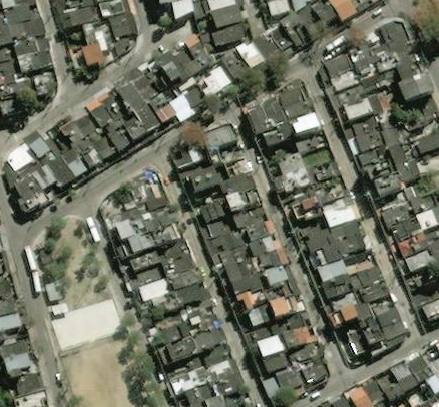

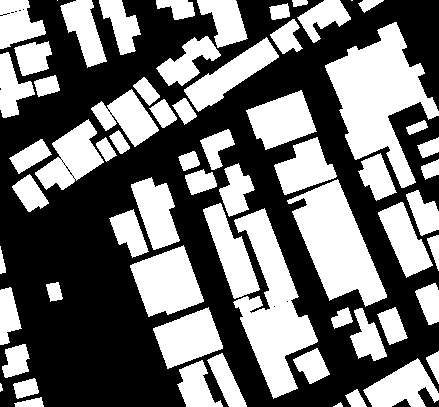

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/4101-AI-Project/processedBuildingLabels/3band/3band/3band_AOI_1_RIO_img6917.tif')
mask = cv2.imread('/content/drive/MyDrive/4101-AI-Project/buildingMaskImages/3band_AOI_1_RIO_img6917.tif')
cv2_imshow(img)
cv2_imshow(mask)

In [ ]:
model.to_gpu(0)

InvalidType: ignored

# Evaluate the model

In [ ]:
from __future__ import division

import numpy as np
import six


def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    """Collect a confusion matrix.
    The number of classes :math:`n\_class` is
    :math:`max(pred\_labels, gt\_labels) + 1`, which is
    the maximum class id of the inputs added by one.
    Args:
        pred_labels (iterable of numpy.ndarray): A collection of predicted
            labels. The shape of a label array
            is :math:`(H, W)`. :math:`H` and :math:`W`
            are height and width of the label.
        gt_labels (iterable of numpy.ndarray): A collection of ground
            truth labels. The shape of a ground truth label array is
            :math:`(H, W)`, and its corresponding prediction label should
            have the same shape.
            A pixel with value :obj:`-1` will be ignored during evaluation.
    Returns:
        numpy.ndarray:
        A confusion matrix. Its shape is :math:`(n\_class, n\_class)`.
        The :math:`(i, j)` th element corresponds to the number of pixels
        that are labeled as class :math:`i` by the ground truth and
        class :math:`j` by the prediction.
    """
    pred_labels = iter(pred_labels)
    gt_labels = iter(gt_labels)

    n_class = 0
    confusion = np.zeros((n_class, n_class), dtype=np.int64)
    for pred_label, gt_label in six.moves.zip(pred_labels, gt_labels):
        if pred_label.ndim != 2 or gt_label.ndim != 2:
            raise ValueError('ndim of labels should be two.')
        if pred_label.shape != gt_label.shape:
            raise ValueError('Shape of ground truth and prediction should'
                             ' be same.')
        pred_label = pred_label.flatten()
        gt_label = gt_label.flatten()

        # Dynamically expand the confusion matrix if necessary.
        lb_max = np.max((pred_label, gt_label))
        if lb_max >= n_class:
            expanded_confusion = np.zeros(
                (lb_max + 1, lb_max + 1), dtype=np.int64)
            expanded_confusion[0:n_class, 0:n_class] = confusion

            n_class = lb_max + 1
            confusion = expanded_confusion

        # Count statistics from valid pixels.
        mask = gt_label >= 0
        confusion += np.bincount(
            n_class * gt_label[mask].astype(int) +
            pred_label[mask], minlength=n_class**2).reshape((n_class, n_class))

    for iter_ in (pred_labels, gt_labels):
        # This code assumes any iterator does not contain None as its items.
        if next(iter_, None) is not None:
            raise ValueError('Length of input iterables need to be same')
    return confusion


def calc_semantic_segmentation_iou(confusion):
    """Calculate Intersection over Union with a given confusion matrix.
    The definition of Intersection over Union (IoU) is as follows,
    where :math:`N_{ij}` is the number of pixels
    that are labeled as class :math:`i` by the ground truth and
    class :math:`j` by the prediction.
    * :math:`\\text{IoU of the i-th class} =  \
        \\frac{N_{ii}}{\\sum_{j=1}^k N_{ij} + \\sum_{j=1}^k N_{ji} - N_{ii}}`
    Args:
        confusion (numpy.ndarray): A confusion matrix. Its shape is
            :math:`(n\_class, n\_class)`.
            The :math:`(i, j)` th element corresponds to the number of pixels
            that are labeled as class :math:`i` by the ground truth and
            class :math:`j` by the prediction.
    Returns:
        numpy.ndarray:
        An array of IoUs for the :math:`n\_class` classes. Its shape is
        :math:`(n\_class,)`.
    """
    iou_denominator = (confusion.sum(axis=1) + confusion.sum(axis=0) -
                       np.diag(confusion))
    iou = np.diag(confusion) / iou_denominator
    return iou


def eval_semantic_segmentation(pred_labels, gt_labels):
    """Evaluate metrics used in Semantic Segmentation.
    This function calculates Intersection over Union (IoU), Pixel Accuracy
    and Class Accuracy for the task of semantic segmentation.
    The definition of metrics calculated by this function is as follows,
    where :math:`N_{ij}` is the number of pixels
    that are labeled as class :math:`i` by the ground truth and
    class :math:`j` by the prediction.
    * :math:`\\text{IoU of the i-th class} =  \
        \\frac{N_{ii}}{\\sum_{j=1}^k N_{ij} + \\sum_{j=1}^k N_{ji} - N_{ii}}`
    * :math:`\\text{mIoU} = \\frac{1}{k} \
        \\sum_{i=1}^k \
        \\frac{N_{ii}}{\\sum_{j=1}^k N_{ij} + \\sum_{j=1}^k N_{ji} - N_{ii}}`
    * :math:`\\text{Pixel Accuracy} =  \
        \\frac \
        {\\sum_{i=1}^k N_{ii}} \
        {\\sum_{i=1}^k \\sum_{j=1}^k N_{ij}}`
    * :math:`\\text{Class Accuracy} = \
        \\frac{N_{ii}}{\\sum_{j=1}^k N_{ij}}`
    * :math:`\\text{Mean Class Accuracy} = \\frac{1}{k} \
        \\sum_{i=1}^k \
        \\frac{N_{ii}}{\\sum_{j=1}^k N_{ij}}`
    The more detailed description of the above metrics can be found in a
    review on semantic segmentation [#]_.
    The number of classes :math:`n\_class` is
    :math:`max(pred\_labels, gt\_labels) + 1`, which is
    the maximum class id of the inputs added by one.
    .. [#] Alberto Garcia-Garcia, Sergio Orts-Escolano, Sergiu Oprea, \
    Victor Villena-Martinez, Jose Garcia-Rodriguez. \
    `A Review on Deep Learning Techniques Applied to Semantic Segmentation \
    <https://arxiv.org/abs/1704.06857>`_. arXiv 2017.
    Args:
        pred_labels (iterable of numpy.ndarray): A collection of predicted
            labels. The shape of a label array
            is :math:`(H, W)`. :math:`H` and :math:`W`
            are height and width of the label.
            For example, this is a list of labels
            :obj:`[label_0, label_1, ...]`, where
            :obj:`label_i.shape = (H_i, W_i)`.
        gt_labels (iterable of numpy.ndarray): A collection of ground
            truth labels. The shape of a ground truth label array is
            :math:`(H, W)`, and its corresponding prediction label should
            have the same shape.
            A pixel with value :obj:`-1` will be ignored during evaluation.
    Returns:
        dict:
        The keys, value-types and the description of the values are listed
        below.
        * **iou** (*numpy.ndarray*): An array of IoUs for the \
            :math:`n\_class` classes. Its shape is :math:`(n\_class,)`.
        * **miou** (*float*): The average of IoUs over classes.
        * **pixel_accuracy** (*float*): The computed pixel accuracy.
        * **class_accuracy** (*numpy.ndarray*): An array of class accuracies \
            for the :math:`n\_class` classes. \
            Its shape is :math:`(n\_class,)`.
        * **mean_class_accuracy** (*float*): The average of class accuracies.
    """
    # Evaluation code is based on
    # https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/
    # score.py#L37
    confusion = calc_semantic_segmentation_confusion(
        pred_labels, gt_labels)
    iou = calc_semantic_segmentation_iou(confusion)
    pixel_accuracy = np.diag(confusion).sum() / confusion.sum()
    class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)

    return {'iou': iou, 'miou': np.nanmean(iou),
            'pixel_accuracy': pixel_accuracy,
            'class_accuracy': class_accuracy,
            'mean_class_accuracy': np.nanmean(class_accuracy)}

In [ ]:
import numpy as np
import cv2
import math

import chainer
import chainer.functions as F
from chainer import cuda, serializers, Variable



class SegmentationModel:

	def __init__(self, model_path, mean, gpu=0):

		# Load model
		self.__model = UNet()
		serializers.load_npz(model_path, self.__model)

		chainer.cuda.get_device(gpu).use()
		self.__model.to_gpu(gpu)

		# Add height and width dimensions to mean 
		self.__mean = mean[np.newaxis, np.newaxis, :]


	def apply_segmentation(self, image):

		image_in, crop = self.__preprocess(image)

		with chainer.using_config('train', False):
			score = self.__model.forward(image_in)
		
		score = F.softmax(score)
		score = cuda.to_cpu(score.data)[0]
		
		top, left, bottom, right = crop
		score = score[:, top:bottom, left:right]
		
		return score


	def apply_segmentation_to_mosaic(self, mosaic, grid_px=800, tile_overlap_px=200):

		h, w, _ = mosaic.shape

		assert ((grid_px + tile_overlap_px * 2) % 16 == 0), "(grid_px + tile_overlap_px * 2) must be divisible by 16"

		pad_y1 = tile_overlap_px
		pad_x1 = tile_overlap_px

		n_y = int(float(h) / float(grid_px))
		n_x = int(float(w) / float(grid_px))
		pad_y2 = n_y * grid_px + 2 * tile_overlap_px - h - pad_y1
		pad_x2 = n_x * grid_px + 2 * tile_overlap_px - h - pad_x1

		mosaic_padded = np.pad(mosaic, ((pad_y1, pad_y2), (pad_x1, pad_x2), (0, 0)), 'symmetric')

		H, W, _ = mosaic_padded.shape
		score_padded = np.zeros(shape=[self.__model.class_num, H, W], dtype=np.float32)

		for yi in range(n_y):
		    for xi in range(n_x):
		        
		        top = yi * grid_px
		        left = xi * grid_px
		        bottom = top + grid_px + 2 * tile_overlap_px
		        right = left + grid_px + 2 * tile_overlap_px
		        
		        tile = mosaic_padded[top:bottom, left:right]
		        
		        score_tile = self.apply_segmentation(tile)
		        
		        score_padded[:, top:bottom, left:right] = score_tile

		score = score_padded[:, pad_y1:-pad_y2, pad_x1:-pad_x2]

		return score


	def __preprocess(self, image):

		h, w, _ = image.shape
		h_padded = int(math.ceil(float(h) / 16.0) * 16)
		w_padded = int(math.ceil(float(w) / 16.0) * 16)

		pad_y1 = (h_padded - h) // 2
		pad_x1 = (w_padded - w) // 2
		pad_y2 = h_padded - h - pad_y1
		pad_x2 = w_padded - w - pad_x1

		image_padded = np.pad(image, ((pad_y1, pad_y2), (pad_x1, pad_x2), (0, 0)), 'symmetric')
		image_in = (image_padded - self.__mean) / 255.0
		image_in = image_in.transpose(2, 0, 1)
		image_in = image_in[np.newaxis, :, :, :]
		image_in = Variable(cuda.cupy.asarray(image_in, dtype=cuda.cupy.float32))

		top, left = pad_y1, pad_x1
		bottom, right = top + h, left + w

		return image_in, (top, left, bottom, right)

In [ ]:
from os import path
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = '/content/drive/MyDrive/4101-AI-Project/dataset/mean.npy'
# import SegmentationModel as Model

# Load trained model
# Modify the the paths based on your trained model location if needed.
mean = np.load('/content/drive/MyDrive/4101-AI-Project/dataset/mean.npy')
model = SegmentationModel("/content/drive/MyDrive/4101-AI-Project/models/logs/model_iter_1821", mean)

In [ ]:
# Load test-set
# Modify the the paths based on your data location if needed.
root = '/content/drive/MyDrive/4101-AI-Project/'
with open( root+"/dataset/test.txt") as f:
    lines = f.readlines()

test_set = []
for line in lines:
    line = line.rstrip()
    test_set.append(line)

In [ ]:
import numpy as np
import cv2

def overlay_mask(image, mask, alpha=0.5, rgb=[255, 0, 0]):
	
	overlay = image.copy()
	overlay[mask] = np.array(rgb, dtype=np.uint8)

	output = image.copy()
	cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

	return output

In [ ]:
def plot_results(test_data, image, score, label, figsize=(4,4)):
    
    building_score = score[1]
    
    building_mask_pred = (np.argmax(score, axis=0) == 1)
    building_overlay_pred = overlay_mask(image, building_mask_pred)
    
    building_mask_gt = (label > 0)
    building_overlay_gt = overlay_mask(image, building_mask_gt)
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(4*figsize[0], figsize[1]))
    
    ax0.imshow(image)
    ax0.set_title('Input ({})'.format(test_data)) 
    
    ax1.imshow(building_score, vmin=0.0, vmax=1.0)
    ax1.set_title('Predicted Building Score') 
    
    ax2.imshow(building_overlay_pred)
    ax2.set_title('Input + Predicted Buildings') 
    
    ax3.imshow(building_overlay_gt)
    ax3.set_title('Input + Ground Truth Buildings') 
    
    plt.show()

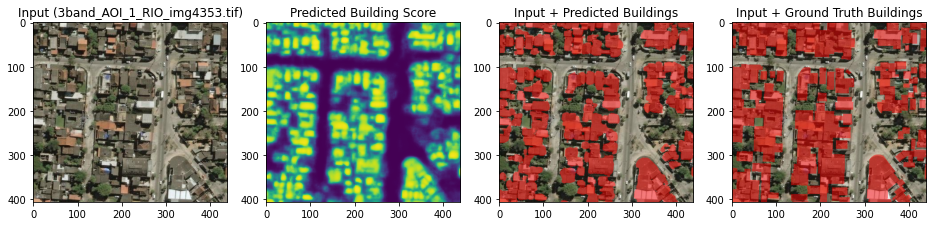

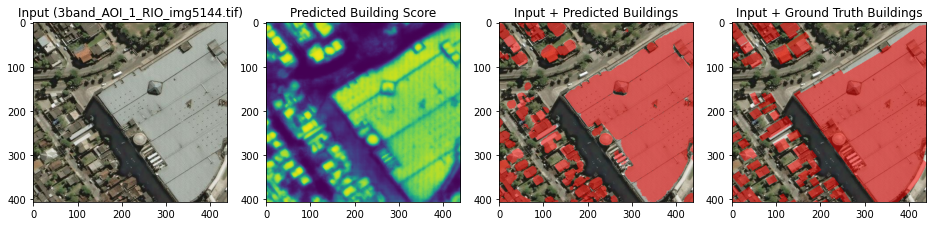

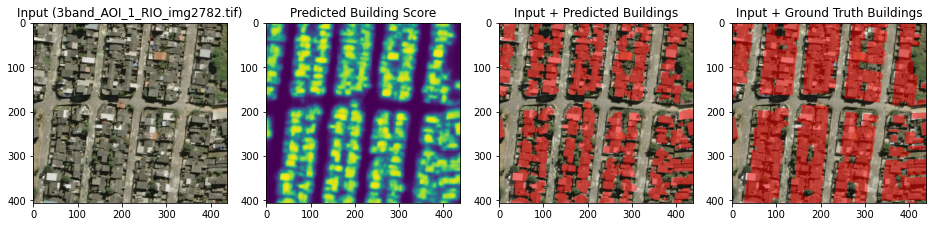

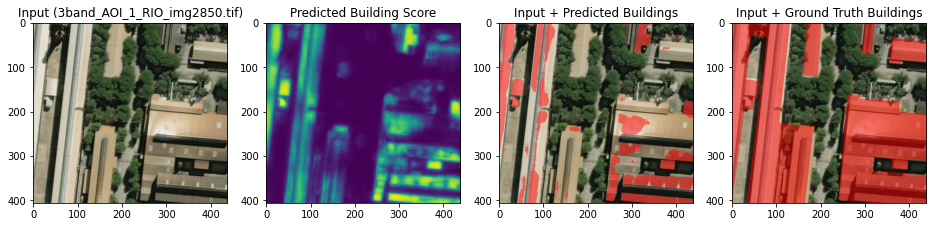

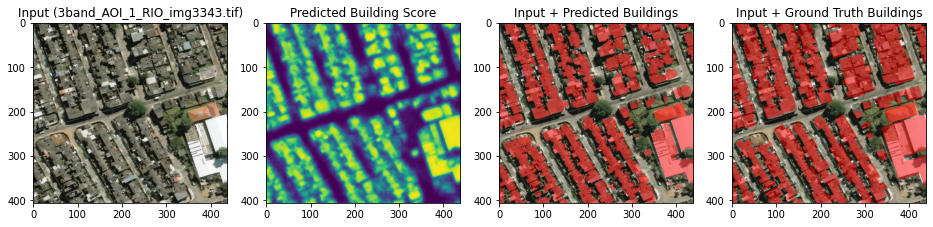

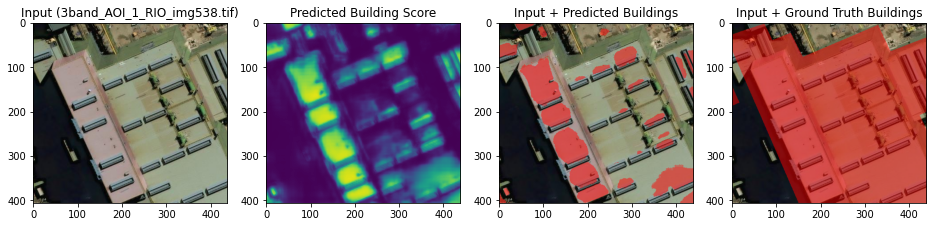

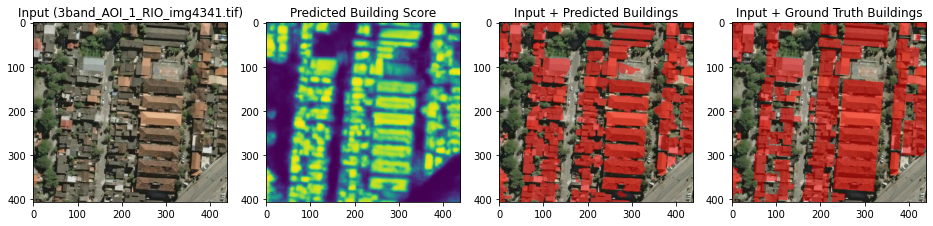

KeyboardInterrupt: ignored

In [ ]:
# Modify the the paths based on your raster image and building label location.
image_dir = root+'processedBuildingLabels/3band/3band'
label_dir = root+'buildingMaskImages'

for test_data in test_set:
    image_path = path.join(image_dir, test_data)
    label_path = path.join(label_dir, test_data)
    
    image = np.array(Image.open(image_path))
    label = np.array(Image.open(label_path))
    
    # To save time, apply segmentation to the images with above a certain amount of buildings
    area_ratio_thresh = 0.5
    building_area = float(np.sum(label > 0))
    total_area = float(label.shape[0] * label.shape[1])
    if building_area / total_area < area_ratio_thresh:
        continue
    
    score = model.apply_segmentation(image)
    
    plot_results(test_data, image, score, label)

print("Finishd.")

In [ ]:
from tqdm import tqdm
image_dir = root+'processedBuildingLabels/3band/3band'
label_dir = root+'buildingMaskImages'
gt_labels = []
pred_labels = []

for test_data in tqdm(test_set):
    image_path = path.join(image_dir, test_data)
    label_path = path.join(label_dir, test_data)
    
    image = np.array(Image.open(image_path))
    label = np.array(Image.open(label_path))
    
    # Make gt_label, ground-truth building mask
    h, w = label.shape
    gt_label = np.zeros(shape=[h, w], dtype=np.int32) # 0: background
    gt_label[label > 0] = 1 # 1: "building"
    
    # Make pred_label, predicted building mask
    score = model.apply_segmentation(image)
    pred_label = np.argmax(score, axis=0)
    
    gt_labels.append(gt_label)
    pred_labels.append(pred_label)

100%|██████████| 1389/1389 [04:45<00:00,  4.87it/s]


In [ ]:
result = eval_semantic_segmentation(pred_labels, gt_labels)
print(result)

{'iou': array([0.94664116, 0.55507448]), 'miou': 0.7508578204450371, 'pixel_accuracy': 0.9499714959908382, 'class_accuracy': array([0.97369624, 0.70551589]), 'mean_class_accuracy': 0.8396060677777277}


In [ ]:
building_class = 1
print("IoU for class Building = ", result['iou'][building_class])
print("Accuracy for class Building = ", result['class_accuracy'][building_class])
confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
print("confusion:")
print(confusion)

tn = confusion[0][0]
fp = confusion[0][1]
tp = confusion[1][1]
fn = confusion[1][0]

precision = float(tp) / float(tp + fp)
recall       = float(tp) / float(tp + fn)

print()
print("precision: ", precision)
print("recall: ", recall)

IoU for class Building =  0.5550744791550192
Accuracy for class Building =  0.7055158910448993
confusion:
[[219544632   5930852]
 [  6444108  15438594]]

precision:  0.7224611251035707
recall:  0.7055158910448993


In [ ]:
import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Image.MAX_IMAGE_PIXELS = 10000000000


In [ ]:
src_mosaic_dir = "../../data/3-Band"
mosaic_dir = "../../data/3-Band_8bit"

if not os.path.exists(mosaic_dir):
    os.makedirs(mosaic_dir)
    
    mosaics = os.listdir(src_mosaic_dir)
    for mosaic in mosaics:
        src = os.path.join(src_mosaic_dir, mosaic)
        dst = os.path.join(mosaic_dir, mosaic)
        
        convert_gtif_to_8bit(src, dst)